In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Load Data

In [2]:
# df = dd.concat([
#     dd.read_parquet('../data/MERGED_DATA_1_parquet'),
#     dd.read_parquet('../data/MERGED_DATA_2_parquet'),
#     dd.read_parquet('../data/MERGED_DATA_3_parquet')
# ])

df = pd.concat([
    pd.read_parquet('../data/2023_9_parquet'),
    pd.read_parquet('../data/2023_10_parquet'),
    pd.read_parquet('../data/2023_11_parquet')
])

# Calculate mean trx of 3 months
df = df.groupby(['PACKAGE_CODE', 'MSISDN', 'FUNCTION_VAS', 'Premium_Number'], as_index=False).agg('mean')

In [2]:
df

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19802699 entries, 0 to 19802698
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   PACKAGE_CODE    string 
 1   MSISDN          int64  
 2   FUNCTION_VAS    string 
 3   Premium_Number  int64  
 4   SYS_TRX         float64
 5   DIGITAL_TRX     float64
 6   KIOSK_POS_TRX   float64
 7   LEGACY_TRX      float64
 8   AGENT_TRX       float64
dtypes: float64(5), int64(2), string(2)
memory usage: 1.3 GB


In [6]:
df.columns

Index(['PACKAGE_CODE', 'MSISDN', 'FUNCTION_VAS', 'Premium_Number', 'SYS_TRX',
       'DIGITAL_TRX', 'KIOSK_POS_TRX', 'LEGACY_TRX', 'AGENT_TRX'],
      dtype='object')

In [3]:
# Average number of packages per MSISDN
df[['MSISDN', 'PACKAGE_CODE']].groupby('MSISDN').count().hist(bins=50);

In [4]:
# System transactions
df[['SYS_TRX']].hist(bins=50)
plt.xlabel('Number of Packages Bought')
plt.ylabel('Count of MSISDN');

In [5]:
# Digital transactions
df['DIGITAL_TRX'].hist(bins=50)
plt.xlabel('Number of Packages Bought')
plt.ylabel('Count of MSISDN');

In [6]:
# Kiosk/POS transactions
df['KIOSK_POS_TRX'].hist(bins=50)
plt.xlabel('Number of Packages Bought')
plt.ylabel('Count of MSISDN');

In [7]:
# Legacy transactions
df['LEGACY_TRX'].hist(bins=50)
plt.xlabel('Number of Packages Bought')
plt.ylabel('Count of MSISDN');

In [8]:
# Agent transactions
df['AGENT_TRX'].hist(bins=50)
plt.xlabel('Number of Packages Bought')
plt.ylabel('Count of MSISDN');

In [9]:
list(df['PACKAGE_CODE'].unique())

In [14]:
df['FUNCTION_VAS'].unique()

<StringArray>
['BUY', 'RC']
Length: 2, dtype: string

In [10]:
# Type of transactions
df['FUNCTION_VAS'].value_counts(ascending=True).plot(kind='barh');

### Merge with package detail features for clustering

In [11]:
package_detail = pd.read_csv('../data/PACK_DETAIL_FOR_CLUSTERING_2.csv')
package_detail.head()

In [4]:
# Rename column, prepare for merging
package_detail.rename(columns={'IPK_CODE': 'PACKAGE_CODE'}, inplace=True)

In [5]:
# Merge
df = df.merge(package_detail, on='PACKAGE_CODE', how='left')
df.dropna(inplace=True)

In [12]:
df.columns

In [13]:
df.head()

In [6]:
# Aggregate feature columns
agg_col = {
    # Actual fields name removed (confidential data) 
    'COLUMN 1': 'first',
    'COLUMN 2': 'sum',
    'COLUMN 3': 'mean',
}

df = df.groupby('MSISDN', as_index=False).agg(agg_col)

In [14]:
df

### Modelling

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist

#### Kmeans

In [ ]:
ss = StandardScaler()
# X = ss.fit_transform(df[df['DIGITAL_TRX'] + df['KIOSK_POS_TRX'] + df['LEGACY_TRX'] + df['AGENT_TRX'] < 8.5].drop(columns='MSISDN'))
X = ss.fit_transform(df.drop(columns='MSISDN'))

In [22]:
# Calculate sillhouette score in chunks
# chunk_size = 5000
# chunks = X.shape[0]/chunk_size
# chunk_list = [[(chunk_size * i) + 1, chunk_size * (i + 1)] for i in range(int(chunks) + 1)]

# chunk_list[0][0] = 0
# chunk_list[-1][0] = 7718210

# labels = km.labels_

# sil_scores = np.array([])
# for chunk in chunk_list:
#     sil_scores = np.append(sil_scores, (silhouette_samples(X[chunk[0]:chunk[1], :], labels[chunk[0]:chunk[1]])))

In [ ]:
# Try multiple K
scores = []

for k in range(2, 100, 5):
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit(X)

    # Calculating the metrics for each k
    inertia = km.inertia_

    sil_scores = []
    for i in range(10):
        sil_scores.append(silhouette_score(X, km.labels_, sample_size=1000, n_jobs=-1))

    # Pairwise distance
    distances = cdist(km.cluster_centers_, km.cluster_centers_)
    distances[distances == 0] = np.nan

    # scores.append([k, inertia, sil])
    scores.append([k, inertia, np.mean(sil_scores), np.nanmean(distances)])

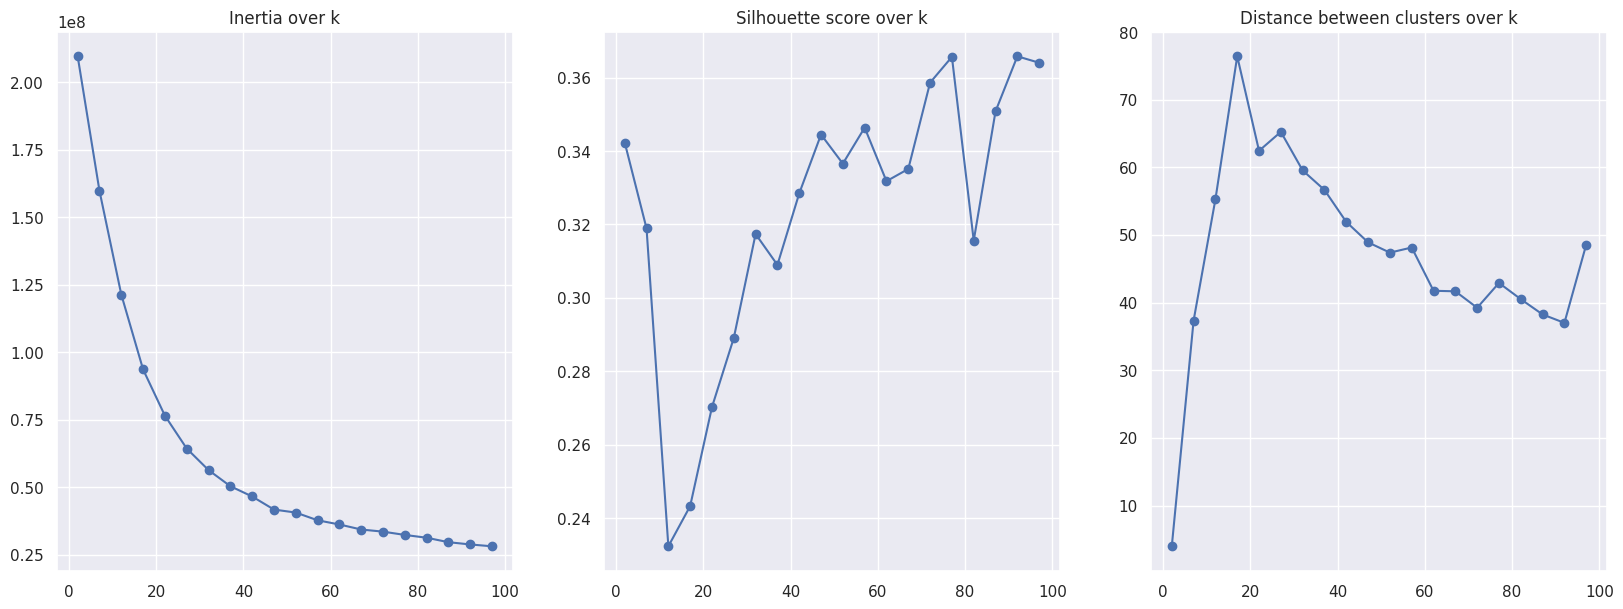

In [10]:
# Plot
# scores_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette_score'])
# fig, axes = plt.subplots(1, 2, figsize=(14, 7))
# axes[0].plot(scores_df.k, scores_df.inertia, marker='o')
# axes[0].set_title('Inertia over k')
# axes[1].plot(scores_df.k, scores_df.silhouette_score, marker='o')
# axes[1].set_title('Silhouette Score over k');

scores_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette', 'distance_between_clusters'])
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].plot(scores_df.k, scores_df.inertia, marker='o')
axes[0].set_title('Inertia over k')
axes[1].plot(scores_df.k, scores_df.silhouette, marker='o')
axes[1].set_title('Silhouette score over k')
axes[2].plot(scores_df.k, scores_df.distance_between_clusters, marker='o')
axes[2].set_title('Distance between clusters over k');

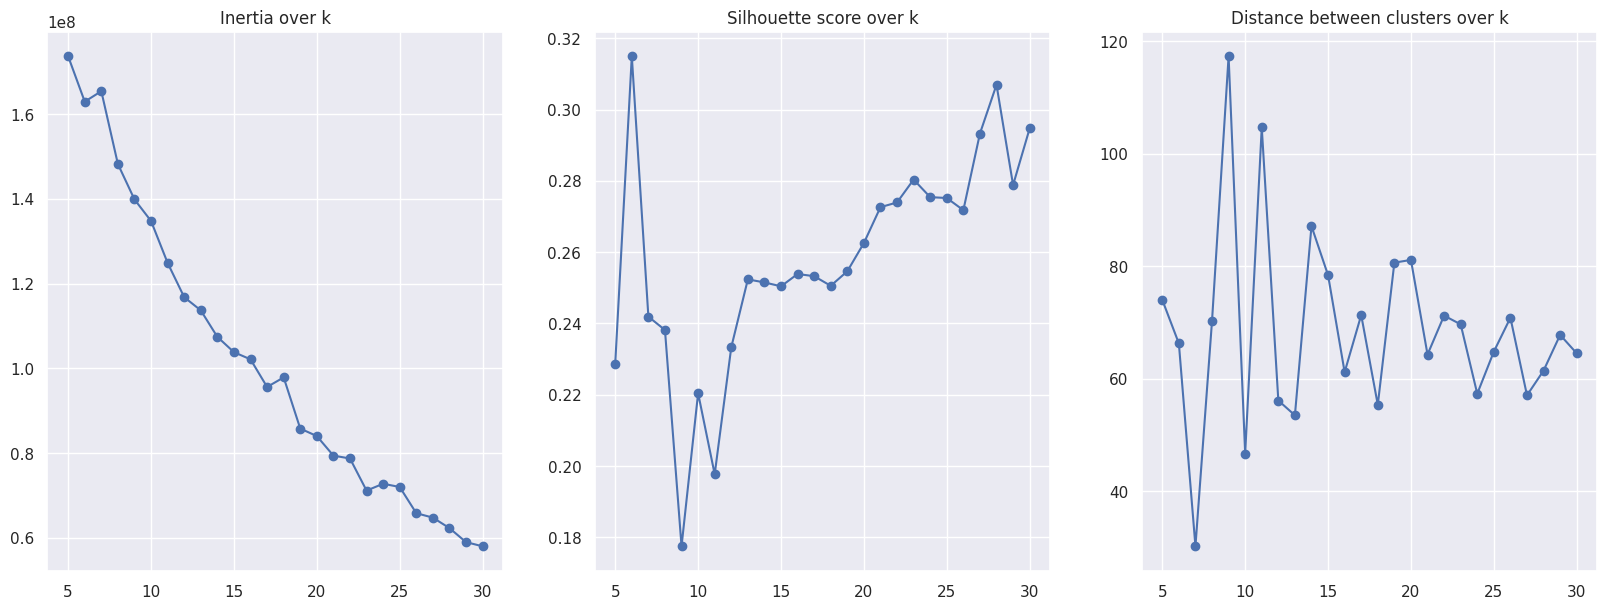

In [11]:
# Drill down to find optimal K
scores = []

for k in range(5, 31):
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit(X)

    # Calculating the metrics for each k
    inertia = km.inertia_

    sil_scores = []
    for i in range(10):
        sil_scores.append(silhouette_score(X, km.labels_, sample_size=1000, n_jobs=-1))

    # Pairwise distance
    distances = cdist(km.cluster_centers_, km.cluster_centers_)
    distances[distances == 0] = np.nan

    # scores.append([k, inertia, sil])
    scores.append([k, inertia, np.mean(sil_scores), np.nanmean(distances)])

scores_df = pd.DataFrame(scores, columns=['k', 'inertia', 'silhouette', 'distance_between_clusters'])
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes[0].plot(scores_df.k, scores_df.inertia, marker='o')
axes[0].set_title('Inertia over k')
axes[1].plot(scores_df.k, scores_df.silhouette, marker='o')
axes[1].set_title('Silhouette score over k')
axes[2].plot(scores_df.k, scores_df.distance_between_clusters, marker='o')
axes[2].set_title('Distance between clusters over k');

In [15]:
# Cluster proportion
pd.DataFrame(km.labels_).value_counts()

#### Best K = 9

In [12]:
km = KMeans(n_clusters=9, n_init='auto')
km.fit(X)

KMeans(n_clusters=9, n_init='auto')

In [16]:
pd.DataFrame(km.labels_).value_counts()

In [7]:
# Push MSISDN with cluster label into file
label_df = pd.read_parquet('../data/clustered_MSISDN.parquet')
df = df.merge(label_df, on='MSISDN')
df.to_parquet('../data/clustered_MSISDN.parquet')